_Ilhem OUASSINI , I2-APP RS1_

__Dans ce notebook, vous trouverez le code, les commentaires, ainsi que les résultats obtenus.__

# LAB5

## Introduction

Dans ce lab, nous allons implémenter et évaluer des arbres de décision pour des tâches de classification sur les jeux de données NSL-KDD et IoT-Detection. Nous explorerons le processus complet, du prétraitement des données à l'évaluation du modèle, en ajustant les paramètres et en évitant le surapprentissage via la réduction d'arbre (tree pruning).



## Dataset Overview

NSL-KDD : Discuter de la manière dont ce jeu de données est utilisé pour la détection d'intrusions, en mettant en évidence les différentes caractéristiques liées au trafic réseau.

IoT-Detection : Mettre en évidence la manière dont ce jeu de données est utilisé pour détecter les comportements malveillants dans les environnements IoT.

## Prétraitement

IoT-Detection : Gérer les valeurs manquantes, l'encodage catégoriel, la normalisation, etc.

## Dataset IOT

In [8]:
# importe de la bibliothèque pandas pour la manipulation des données
import pandas as pd

# charge le fichier CSV contenant les données IoT dans un DataFrame
df = pd.read_csv('label_feature_IOT.csv')
# affiche les premières lignes du DataFrame
df.head()  

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,TCP_Assistant,281,20,64,6,36171,443,1,1,1597,20,241,0,0,0x02,0xe0e0,0x9e5d,0x0018,0xc650
1,TCP_Assistant,40,20,64,6,36171,443,242,93,1597,20,0,0,0,0x02,0xe0e1,0x9f4d,0x0010,0xd2b2
2,TCP_Assistant,52,20,64,6,45990,443,1,1,406,32,0,1,0,0x02,0x5aee,0xa23f,0x0010,0x2147
3,TCP_Assistant,121,20,64,6,36836,443,1,1,406,32,69,2,0,0x02,0x8539,0x4150,0x0018,0xb3dc
4,TCP_Assistant,90,20,64,6,36836,443,70,1,406,32,38,2,0,0x02,0x853a,0x416e,0x0018,0x450f


In [9]:
# importe la classe LabelEncoder pour encoder les caractéristiques
from sklearn.preprocessing import LabelEncoder
# crée une instance de LabelEncoder
le = LabelEncoder()
# transforme chaque caractéristique en un entier
df['Label'] = le.fit_transform(df['Label'])
# affiche les 5 premières lignes du DataFrame
df.head()

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,0,281,20,64,6,36171,443,1,1,1597,20,241,0,0,0x02,0xe0e0,0x9e5d,0x0018,0xc650
1,0,40,20,64,6,36171,443,242,93,1597,20,0,0,0,0x02,0xe0e1,0x9f4d,0x0010,0xd2b2
2,0,52,20,64,6,45990,443,1,1,406,32,0,1,0,0x02,0x5aee,0xa23f,0x0010,0x2147
3,0,121,20,64,6,36836,443,1,1,406,32,69,2,0,0x02,0x8539,0x4150,0x0018,0xb3dc
4,0,90,20,64,6,36836,443,70,1,406,32,38,2,0,0x02,0x853a,0x416e,0x0018,0x450f


In [10]:
# liste des colonnes contenant des valeurs en hexadécimal
hex_columns = ['IPFlags', 'IPID', 'IPchecksum', 'TCPflags', 'TCPChecksum']
# conversion des valeurs hexadécimales en décimaux pour les colonnes concernées 
for col in hex_columns:
    df[col] = df[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)

# suppression de la colonne Label pour obtenir seulement les 18 caractérisques (donnée d'entrée)
X = df.drop('Label', axis=1)
# création d'une variable qui concerne uniquement la colonne Label (résultat à prédire)
y = df['Label']
df.head()

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,0,281,20,64,6,36171,443,1,1,1597,20,241,0,0,2,57568,40541,24,50768
1,0,40,20,64,6,36171,443,242,93,1597,20,0,0,0,2,57569,40781,16,53938
2,0,52,20,64,6,45990,443,1,1,406,32,0,1,0,2,23278,41535,16,8519
3,0,121,20,64,6,36836,443,1,1,406,32,69,2,0,2,34105,16720,24,46044
4,0,90,20,64,6,36836,443,70,1,406,32,38,2,0,2,34106,16750,24,17679


In [11]:
# importe train_test_split pour diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# division du dataset : d'entraînement et de test
# 70% des données seront utilisées pour l'entraînement
# 30% des données seront utilisées pour les tests 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# importe StandardScaler pour ajuter les caractéristiques 
from sklearn.preprocessing import StandardScaler
# création d'un objet StandardScaler 
scaler = StandardScaler()
# ajustement du scaler sur les données d'entraînement et transformation
X_train = scaler.fit_transform(X_train)
# transformation des données de test, utilisant le même scaler
X_test = scaler.transform(X_test)

## Building a Decision Tree Classifier

Pour le dataset IOT

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Load data (Assume X and y are preprocessed feature matrix and labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[ 439    0    0    0    0]
 [   0 1600    1    0    0]
 [   0    0  191    0    0]
 [   1    0    0   41    0]
 [   0    0    0    0  355]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       1.00      1.00      1.00      1601
           2       0.99      1.00      1.00       191
           3       1.00      0.98      0.99        42
           4       1.00      1.00      1.00       355

    accuracy                           1.00      2628
   macro avg       1.00      1.00      1.00      2628
weighted avg       1.00      1.00      1.00      2628



## Evaluating the Model

__Discuter des métriques d'évaluation, en particulier la précision, le rappel, le score F1 et la matrice de confusion.__

Les métriques d'évaluation montrent que le modèle de classification pour la détection des comportements malveillants dans les environnements IoT est extrêmement performant. La précision et le rappel sont proches de 1 pour toutes les classes indiquant que le modèle fait très peu d'erreurs. Le score F1 élevé reflète un bon équilibre entre la précision et le rappel. La matrice de confusion révèle que presque toutes les prédictions sont correctes avec seulement quelques erreurs mineures. Globalement le modèle a une exactitude presque parfaite ce qui montre son efficacité pour cette tâche.


__Expérimenter avec différents paramètres pour observer le surapprentissage/sous-apprentissage.__


## Sous-apprentissage

Nous avons un modèle avec très faible depth qui va mal se comporter à la fois sur l'ensemble d'entraîtement et l'ensemble de test. En effet, il ne pourra pas suffisamment séparer les classes.

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Load data (Assume X and y are preprocessed feature matrix and labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=42)
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 439    0    0    0    0]
 [ 216 1385    0    0    0]
 [ 191    0    0    0    0]
 [  42    0    0    0    0]
 [   0    0    0    0  355]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       439
           1       1.00      0.87      0.93      1601
           2       0.00      0.00      0.00       191
           3       0.00      0.00      0.00        42
           4       1.00      1.00      1.00       355

    accuracy                           0.83      2628
   macro avg       0.50      0.57      0.52      2628
weighted avg       0.83      0.83      0.81      2628



C:\Users\ouass\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ouass\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ouass\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Surapprentissage 

Le modèle a une performance presque parfaite sur les données d'entraîtement mais sa performance sur l'ensemble de test peut probablement se dégrader avec le surapprentissage.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Load data (Assume X and y are preprocessed feature matrix and labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=50, random_state=42)
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 439    0    0    0    0]
 [   0 1600    1    0    0]
 [   0    0  191    0    0]
 [   1    0    0   41    0]
 [   0    0    0    0  355]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       1.00      1.00      1.00      1601
           2       0.99      1.00      1.00       191
           3       1.00      0.98      0.99        42
           4       1.00      1.00      1.00       355

    accuracy                           1.00      2628
   macro avg       1.00      1.00      1.00      2628
weighted avg       1.00      1.00      1.00      2628



## Feature Importance

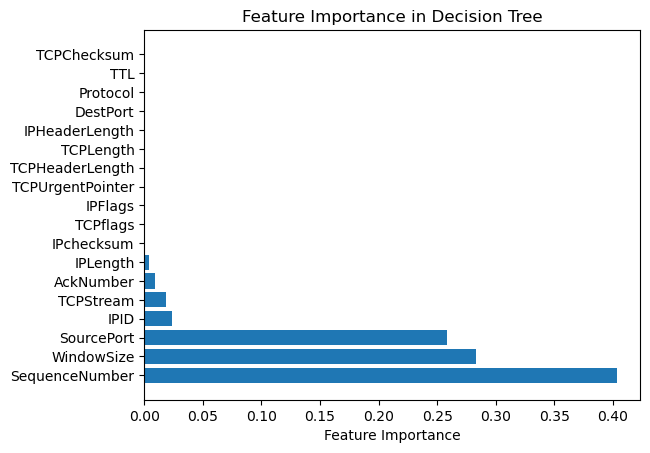

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
feature_importance = clf.feature_importances_
feature_names = X.columns # Assuming you have a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance':
feature_importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()

Interprétation :

La caractéristique la plus importante du modèle est SequenceNumber avec une importance de 0.40, suivie de WindowSize à 0.27, et SourcePort à 0.25. En revanche, une autre caractéristique n'a qu'une importance de 0.01, indiquant qu'elle a très peu d'impact sur les décisions du modèle.

## Prétraitement

NSL-KDD : Convertir les caractéristiques catégorielles en valeurs numériques (si applicable). Vous pourriez aussi avoir besoin de normaliser certaines caractéristiques.


## Dataset NSL-KDD

In [25]:
import pandas as pd
# Charger les ensembles de données d'entraînement et de test NSL-KDD
column_names = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level']) # Add the 43 column names from the NSL-KDD dataset
# Lire le fichier d'entraînement 'KDDTrain+.txt' sans en-tête, en utilisant les noms de colonnes spécifiés
train_df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
# Lire le fichier de test 'KDDTest+.txt' sans en-tête, en utilisant les noms de colonnes spécifiés
test_df = pd.read_csv('KDDTest+.txt', header=None, names=column_names)
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [26]:
# Transformer les valeurs de la colonne 'outcome' en valeurs binaires :
# Attribuer 0 si l'étiquette est 'normal', sinon attribuer 1
Trained_attack = train_df.outcome.map(lambda a: 0 if a == 'normal' else 1)
Tested_attack = test_df.outcome.map(lambda a: 0 if a == 'normal' else 1)
# Ajouter la colonne 'classification' au DataFrame d'entraînement avec les valeurs transformées
train_df['classification'] = Trained_attack
# Ajouter la colonne 'classification' au DataFrame de test avec les valeurs transformées
test_df['classification'] = Tested_attack

In [27]:
from sklearn.preprocessing import LabelEncoder
# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()
# Encoder les valeurs de la colonne 'outcome' dans l'ensemble d'entraînement et ajouter une nouvelle colonne 'label'
train_df['label'] = label_encoder.fit_transform(train_df['outcome'])
# Encoder les valeurs de la colonne 'outcome' dans l'ensemble de test en utilisant le même encodage et ajouter une nouvelle colonne 'label'
test_df['label'] = label_encoder.fit_transform(test_df['outcome'])

In [28]:
from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder pour chaque colonne catégorielle
label_encoder = LabelEncoder()

# Encoder les colonnes dans l'ensemble d'entraînement
train_df['protocol_type'] = label_encoder.fit_transform(train_df['protocol_type'])
train_df['service'] = label_encoder.fit_transform(train_df['service'])
train_df['flag'] = label_encoder.fit_transform(train_df['flag'])

# Encoder les colonnes dans l'ensemble de test en utilisant les mêmes encodages
test_df['protocol_type'] = label_encoder.fit_transform(test_df['protocol_type'])
test_df['service'] = label_encoder.fit_transform(test_df['service'])
test_df['flag'] = label_encoder.fit_transform(test_df['flag'])

# Afficher les DataFrames modifiés
train_df
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level,classification,label
0,0,1,45,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1,14
1,0,1,45,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1,14
2,2,1,19,9,12983,0,0,0,0,0,...,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,0,16
3,0,0,13,9,20,0,0,0,0,0,...,1.00,0.28,0.00,0.0,0.00,0.00,saint,15,1,24
4,1,1,55,2,0,15,0,0,0,0,...,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,0,16
22540,0,1,22,9,317,938,0,0,0,0,...,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,0,16
22541,0,1,22,9,54540,8314,0,0,0,2,...,0.00,0.00,0.00,0.0,0.07,0.07,back,15,1,1
22542,0,2,11,9,42,42,0,0,0,0,...,0.00,0.00,0.00,0.0,0.00,0.00,normal,21,0,16


In [29]:
# Supprime la colonne 'outcome' des ensembles de données d'entraînement et de test
train_df = train_df.drop(columns=['outcome','label','level'])
test_df = test_df.drop(columns=['outcome','label','level'])

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Définir les caractéristiques (features) et la cible (target)
X_train = train_df.drop(columns=[ 'land', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
                    'count', 'srv_count', 'num_failed_logins', 'num_compromised', 'num_root', 
                    'num_file_creations', 'num_shells', 'num_access_files'])

y_train = train_df['classification']

X_test = test_df.drop(columns=[ 'land', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
                    'count', 'srv_count', 'num_failed_logins', 'num_compromised', 'num_root', 
                    'num_file_creations', 'num_shells', 'num_access_files'])

y_test = test_df['classification']

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Building a Decision Tree Classifier

Pour le dataset NSL-KDD

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
clf.fit(X_train_scaled, y_train)
# Make predictions
y_pred = clf.predict(X_test_scaled)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 9711     0]
 [    0 12833]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9711
           1       1.00      1.00      1.00     12833

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



## Evaluating the Model

__Discuter des métriques d'évaluation, en particulier la précision, le rappel, le score F1 et la matrice de confusion.__

Les résultats du modèle sur le dataset NSL-KDD montrent une performance parfaite avec une précision un rappel et un score F1 de 1.00 pour les deux classes. La matrice de confusion indique que le modèle a correctement classé 9711 exemples de la classe "normal" et 12833 exemples de la classe "attaque" sans aucune erreur. L'exactitude globale atteint 100% ce qui suggère que le modèle a appris à distinguer efficacement les classes. Cependant cette performance exceptionnelle soulève des questions sur le risque de surapprentissage.

__Expérimenter avec différents paramètres pour observer le surapprentissage/sous-apprentissage.__


## Sous-apprentissage

Nous avons un modèle avec très faible depth qui va mal se comporter à la fois sur l'ensemble d'entraîtement et l'ensemble de test. En effet, il ne pourra pas suffisamment séparer les classes.

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=42)
clf.fit(X_train_scaled, y_train)
# Make predictions
y_pred = clf.predict(X_test_scaled)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 9711     0]
 [    0 12833]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9711
           1       1.00      1.00      1.00     12833

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



## Surapprentissage 

Le modèle a une performance presque parfaite sur les données d'entraîtement mais sa performance sur l'ensemble de test peut probablement se dégrader avec le surapprentissage.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=50, random_state=42)
clf.fit(X_train_scaled, y_train)
# Make predictions
y_pred = clf.predict(X_test_scaled)
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 9711     0]
 [    0 12833]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9711
           1       1.00      1.00      1.00     12833

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



## Feature Importance

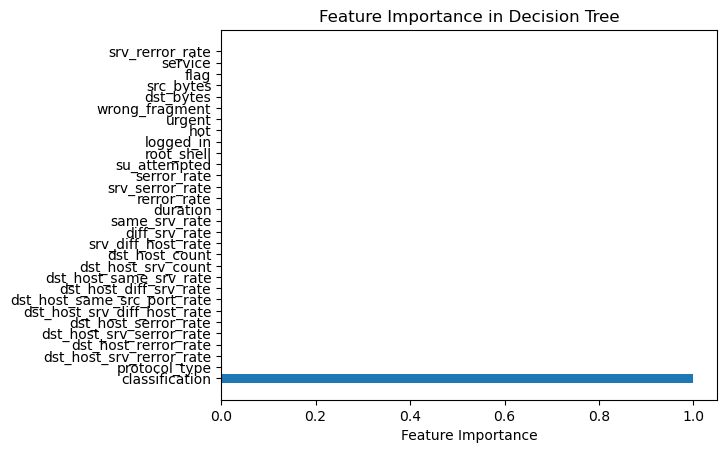

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
feature_importance = clf.feature_importances_
feature_names = X_test.columns # Assuming you have a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance':
feature_importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()

Interprétation :

Une seule caractéristique "classification" a une importance de 1.00 tandis que toutes les autres caractéristiques ont 0. Cela indique que le modèle dépend entièrement de cette caractéristique pour ses décisions. Cela peut signaler un risque de surapprentissage car le modèle pourrait ne pas bien généraliser à de nouvelles données. Il est important d'examiner cette caractéristique pour comprendre pourquoi elle est si influente et de tester d'autres modèles pour voir s'ils capturent mieux les relations entre les caractéristiques.






